In [1]:
import pybullet as p
import numpy as np
import tensorflow as tf

from pybullet_robot import PyBulletRobot, W, H

import sys, glob, time
import pandas as pd 
import collections

from IPython.display import clear_output
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
gui = True
r = PyBulletRobot(4, 1, render=gui)

*** Initializing PyBulletRobot(ns=4, render=True) ...
*** Initializing PyBulletRobot() done


In [3]:
def mk_model(N, L):
    inputs = layer = tf.keras.Input(shape=(7,))
    
    for _ in range(L):
        layer = tf.keras.layers.Dense(N, activation='relu')(layer)
        
    outputs = tf.keras.layers.Dense(6, activation='tanh')(layer)

    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

#print(model.summary())

In [4]:
# X - cam_p + cam_o (quaternion) - 7
# Y - phis - 3 * 2 = 6
def mk_xy(M):
    # 
    X = np.zeros((M, 7))
    Y = np.zeros((M, 6))

    Y[:,0] = np.random.uniform(low=-0.6, high=0, size=(M))
    Y[:,2] = np.random.uniform(low=0.3, high=0.8, size=(M))
    Y[:,4] = np.random.uniform(low=0.3, high=0.8, size=(M))

    Y[:,1] = np.random.uniform(low=-0.6, high=0.6, size=(M))
    Y[:,3] = np.random.uniform(low=-0.6, high=0.6, size=(M))
    Y[:,5] = np.random.uniform(low=-0.6, high=0.6, size=(M))

    for i in range(M):
        phis = Y[i,:].reshape(-1, 2)
        phis = np.append(phis, [phis[-1]], axis=0)
        
        r.step(phis)
        cam_p, cam_o = r.getHeadcamPO()
        X[i] = cam_p + cam_o
    
    return X, Y

#mk_xy(1)

In [5]:
# plots loss and metrics for training and validation
def plot_fh(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [6]:
# plots given data_dict
def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [7]:
def set_robot_pose(alpha):
    cam_p = [0.23, 0.0, 0.67]
    
    # getQuaternionFromEuler (the roll around the X, pitch around Y and yaw around the Z axis)
    cam_o = r.euler2orn(alpha, np.pi/2, 0)
    cam_v, cam_u = r.orn2vu(cam_o)

    test_X = np.array([cam_p + cam_o], dtype=np.float32)
    pred_phis = model.predict(test_X)
    
    pred_phis = pred_phis.reshape(-1, 2)
    pred_phis = np.append(pred_phis, [pred_phis[-1]], axis=0)    
    r.step(pred_phis)
    pvu = r.getHeadcamPVU()

    r.getCameraImage()
    return [cam_p, cam_v, cam_u], pvu, pred_phis.reshape(-1)

In [8]:
X, Y = mk_xy(10000000)
print("Shape of X=%s and Y=%s" % (X.shape, Y.shape))

Shape of X=(10000000, 7) and Y=(10000000, 6)


In [9]:
MAX_ALPHA = np.pi/4
D_ALPHA = 0.025

alpha = -MAX_ALPHA
dalpha = D_ALPHA

def eval_model(model):
    data = collections.defaultdict(list)

    for alpha in np.arange(-MAX_ALPHA, MAX_ALPHA+D_ALPHA, D_ALPHA):
        pvu0, pvu1, phis = set_robot_pose(alpha)

        if False:
            data['cam_vx0'].append(pvu0[1][0])
            data['cam_vx1'].append(pvu1[1][0])
            data['cam_vy0'].append(pvu0[1][1])
            data['cam_vy1'].append(pvu1[1][1])
            data['cam_vz0'].append(pvu0[1][2])
            data['cam_vz1'].append(pvu1[1][2])

        if False:
            data['cam_ux0'].append(pvu0[2][0])
            data['cam_ux1'].append(pvu1[2][0])
            data['cam_uy0'].append(pvu0[2][1])
            data['cam_uy1'].append(pvu1[2][1])
            data['cam_uz0'].append(pvu0[2][2])
            data['cam_uz1'].append(pvu1[2][2])

        if True:
            for i in range(phis.shape[0]-2):
                data['phi%d' % i].append(phis[i])

        live_plot(data)
    return data


*** pose2phis-128-4 ***
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 9980000 samples, validate on 20000 samples
Epoch 1/12
9980000/9980000 [==============================] - 630s 63us/sample - loss: 0.0050 - mean_absolute_error: 0.0408 - val_loss: 0.0041 - val_mean_absolute_error: 0.0370
Epoch 2/12
9980000/9980000 [==============================] - 630s 63us/sample - loss: 0.0041 - mean_absolute_error: 0.0350 - val_loss: 0.0035 - val_mean_absolute_error: 0.0311
Epoch 3/12
9980000/9980000 [==============================] - 634s 63us/sample - loss: 0.0038 - mean_absolute_error: 0.0332 - val_loss: 0.0035 - val_mean_absolute_error: 0.0314
Epoch 4/12
9980000/9980000 [==============================] - 635s 64us/sample - loss: 0.0037 - mean_absolute_error: 0.0323 - val_loss: 0.0036 - val_mean_absolute_error: 0.0303
Epoch 5/12
9980000/9980000 [==============================] - 634s 64us/sample - loss: 0.0036 - mean_absolute_error: 0.0316 - val_loss

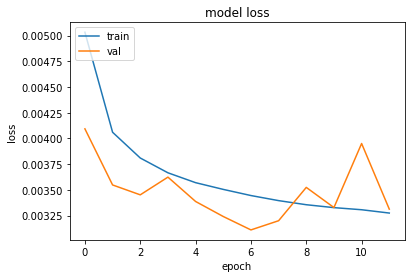

In [10]:
for N in [128]:
    for L in [4]:
        name = 'pose2phis-%d-%d' % (N, L)
        print("\n*** %s ***" % name)

        model = mk_model(N, L)
        h = model.fit(X, Y, epochs=12, shuffle=True, validation_split=0.002, verbose=1)
        plot_fh(h)

        model.save(name)

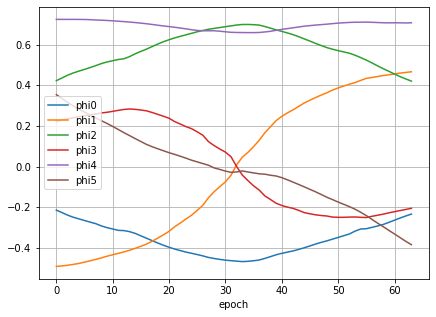

In [13]:
model = tf.keras.models.load_model('pose2phis-128-4')
_ = eval_model(model)

    Y[:,0] = np.random.uniform(low=-0.6, high=0, size=(M))
    Y[:,2] = np.random.uniform(low=0.3, high=0.8, size=(M))
    Y[:,4] = np.random.uniform(low=0.3, high=0.8, size=(M))

    Y[:,1] = np.random.uniform(low=-0.6, high=0.6, size=(M))
    Y[:,3] = np.random.uniform(low=-0.6, high=0.6, size=(M))
    Y[:,5] = np.random.uniform(low=-0.6, high=0.6, size=(M))